<a href="https://colab.research.google.com/github/jdberkson/OPTI-556-Computational-Imaging/blob/main/FinalProject_JoelBerkson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gamma Distortion Correction

In most display systems, whether it be LED screens, projectors, or even cameras, the brightness response is nonlinear compared to the true brightness desired/observed. This is typically represented as a gamma factor $I^\gamma$, where linear response is $\gamma$ = 1. Usually it is beneficial in display systems to have a gamma factor greater than 1, which will look more natural to our eye, but in some systems this is undesirable. If you desire to recover the inital image.

This is the case in any metrology system that utilizes a phase shifting algorithm (PSA). This includes Phase Shifting Interferometers (PSI), Phase Measuring Deflectometry (PMD), Fringe Projection Profilometry (FPP), and others involving phase shifted patterns.

For these systems the ideal pattern takes the form of:

$$
I_n(x) = A+Bsin(\omega_ox+n*2\pi/N+\phi(x)) \tag{Eq. 1}
$$

Where N is the number of phase shifts, and n denotes the nth pattern, $\omega_o$ is the pattern frequency. The goal of a PSA is to recover $\phi(x)$, which effectively encodes the surface under test with a phase, which is then converted to depth/slope information, depending on the metrology method being used. One of the most common ways to recover this phase is through what's known as a the PSA LSQ (Least Squares):

$$
\phi(x,y) = arctan(\frac{\sum_{n=0}^{N} I_n(x,y)sin(2\pi n/N)}{ \sum_{n=0}^{N} I_n(x,y)cos(2\pi n/N) }) \tag{Eq. 2}
$$

This equation effectively least squares fits a point on the fringe pattern, and can perfectly recover the phase, given a perfect input pattern.
This issue is, the pattern never perfect in real life. There's noise, gamma distortion, saturation, etc. In this project, I will only address gamma distortion. by adding the exponential gamma factor to Eq. 1:

$$
I_n(x)^\gamma = (A+Bsin(\omega_ox+n*2\pi/N+\phi(x)))^\gamma \tag{Eq. 3}
$$

Writing this as a fourier series in exponential form:

$$
I_n(x)^\gamma = A+\sum_{k=1}^{\infty}B_ksin(k[\omega_ox+n*2\pi/N+\phi(x))]) \tag{Eq. 4}
$$

This produces the kth harmonic terms with ampltitude $B_k$. When $\gamma \neq 1$, and the phase shited series from Eq. 1 is used with the PSA LSQ in Eq. 2, the resulting phase will have unwanted ripples at the higher freqeuncy harmonics of the original pattern, which will then affect the final measurement.

There are many methods that already exist to remove gamma distortion, but almost all of them involve designing a frequency filter to remove the higher order harmonics from the phase map, but this method doesn't always work perfectly, especially if the fringe frequency varies across the field of view, which is often the case for skewed camera/projector perspectives. My goal is that the gamma value can be estimated by training a CNN on just one image of the fringes at a time, and then the inverse can be applied to recover the fringe pattern $I_{actual} = I_{measured}^{1/\gamma}$

It's not likely this method will work (simply because it seems too obvious, someone would have done it already). I will also try to rectify the images based on what the correct image should look like.


I will use fairly large images to make them more realistic to real camera images (1024x1024). Then I will generate training data with the following parameters randomized

1. Fringe period, between some bounds of ~5 fringes to 20 fringes over the image
2. Fringe orientation (clocking)
3. A linear term in x and y added to the fringe period (within some bounds). This would nicely simulate a projector with the fringes at a non-normal incidence with a plane.

The input data to the network will be the above randomized fringe pattern, with an added random gamma factor between 0.8 and 1.8.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
import math
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})

In [ ]:
def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig
def sigmoid_inv(sig):
  x = math.log(sig/(1-sig))
  return x

In [ ]:
def createFringePattern(X,Y,fringePeriod,clockingangle,slope):
  
  
  fringePeriodwDistortion = fringePeriod*(1+slope*X)
  Pattern = (0.5+0.5*np.cos(2*np.pi*X/(fringePeriodwDistortion)))
  Pattern = ndimage.rotate(Pattern,clockingangle,reshape=True)
  
  return Pattern[1024:2048,1024:2048]

In [ ]:
X = np.linspace(0,3072,num=3072)
Y = np.linspace(0,3072,num=3072)
X,Y = np.meshgrid(X,Y)
fringePeriodBounds = [5, 50]
gammaBounds = [.8, 1.8]
slopeBounds = [0,.002]
N = 200

PatternCorrect = np.zeros([N,1024,1024])
PatternGamma = np.zeros([N,1024,1024])
clockingangle = np.zeros(N)
gamma = np.zeros(N)
gamma_squished = np.zeros(N)
period = np.zeros(N)
slope = np.zeros(N)

for i in range(N):
  clockingangle[i] = np.random.random_sample()*360
  gamma[i] = np.random.random_sample()*(gammaBounds[1]-gammaBounds[0])+gammaBounds[0]
  period[i] = np.random.random_sample()*(fringePeriodBounds[1]-fringePeriodBounds[0])+fringePeriodBounds[0]
  slope[i] = np.random.random_sample()*(slopeBounds[1]-slopeBounds[0])+slopeBounds[0]

  PatternCorrect[i,:,:] = createFringePattern(X,Y,period[i],clockingangle[i],slope[i])
  PatternGamma[i,:,:] = PatternCorrect[i,:,:]**gamma[i]
  gamma_squished[i] = gamma[i]-.8

In [ ]:
print(gamma)
with open('/content/drive/My Drive/FringePatterns.npy', 'wb') as f:
    np.savez(f, PatternCorrect,PatternGamma,gamma)

[0.9805292  1.57411659 0.98226519 0.92373769 1.77665287 1.07965104
 1.45697679 1.30342486 1.33236989 0.81218459 1.07953647 1.64596405
 1.09877611 1.20944801 1.05629006 1.14206874 1.1377318  1.65542875
 1.37562683 1.33348504 1.1692412  1.19226338 1.47031149 0.87545968
 1.09369002 1.77172559 0.96637952 1.54705935 1.50470468 1.34114061
 1.56000237 0.99807135 1.69510785 1.03168617 1.61819606 1.31486188
 0.88542877 0.92467062 1.56253563 0.98359697 1.2921834  1.50294257
 1.65281297 1.50658527 0.94305977 1.12442128 0.95728903 1.21742296
 1.26062869 1.78928078 1.76779561 1.04295929 1.14888791 1.49030712
 1.2292043  1.6797642  1.36677668 1.2680587  0.85177991 0.97200066
 1.39492544 1.3780741  1.58534589 1.30503085 1.67298378 1.02786204
 1.4993456  1.60022213 0.95856223 1.21355167 1.21582682 0.90624841
 1.24269185 1.52099331 0.88050985 0.93209763 1.02913773 1.41201083
 1.3656508  1.68643542 0.99491136 1.02865555 1.20763013 1.2975415
 1.77431165 1.06759498 1.55282168 1.35661105 0.97291545 0.82259

In [3]:
with open('/content/drive/My Drive/FringePatterns.npy', 'rb') as f:
    data = np.load(f)
    PatternCorrect = data['arr_0']
    PatternGamma = data['arr_1']
    gamma = data['arr_2']
    gamma_squished = gamma -.8

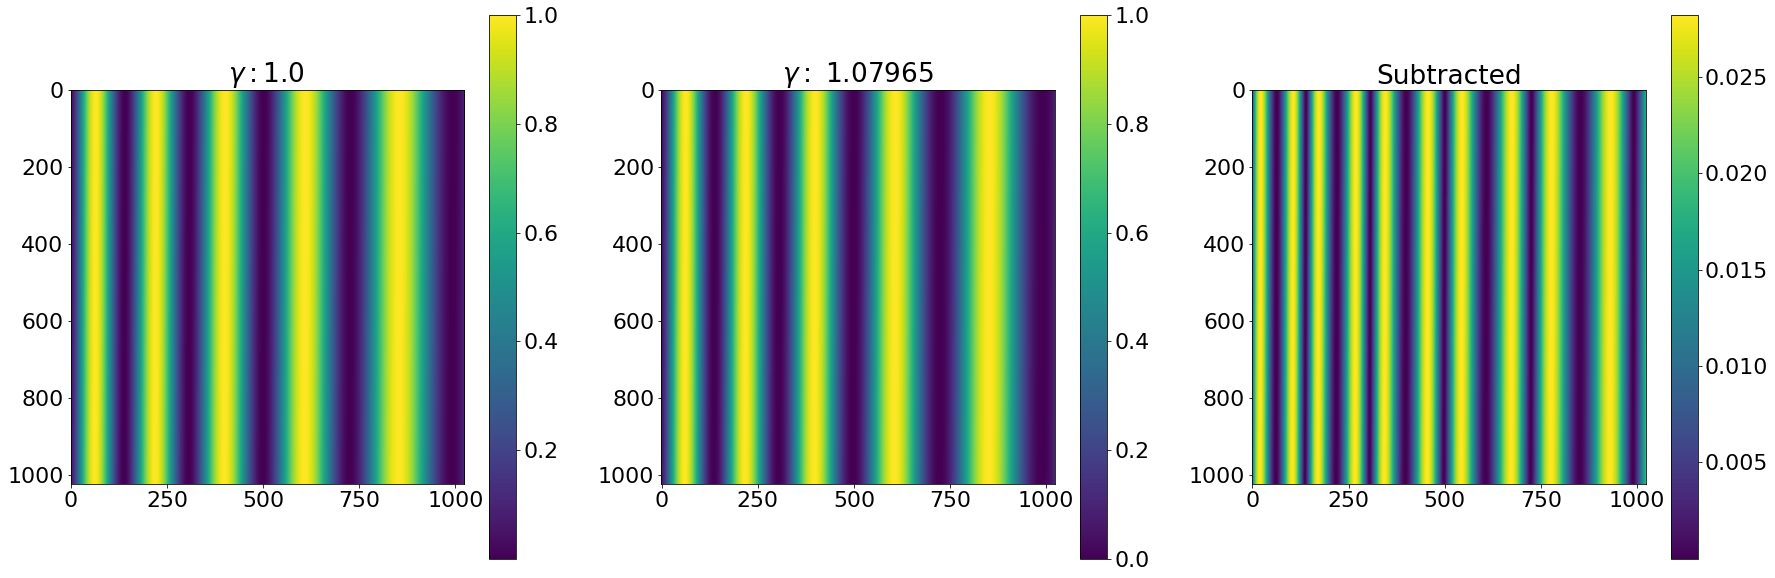

In [42]:
n = 5
plt.subplot(1,3,1)
plt.imshow(PatternCorrect[n,:,:])
plt.title('$\gamma: 1.0$ ')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(PatternGamma[n,:,:])
plt.title('$\gamma:$ ' + str(round(gamma[n],ndigits=5)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(PatternCorrect[n,:,:]-PatternGamma[n,:,:])
plt.title('Subtracted')
plt.colorbar()

First, I tried to set up a CNN to estimate gamma directly. I tried different combinations of convolutions and hidden layers, below is the best performing one. There may be better solutions, but I just didn't have enough computing power to try enough different models/use more training data. 

This network is very prone to overfitting. If i use the same validation data as training data, the model converges really well (mean squared error about .01, which is a good estimation of the gamma factor!). But when used on test data, it isn't even close, about 0.1 mean squared error. 


In [8]:
model = keras.Sequential()
model.add(layers.Conv2D(64, (8, 8), strides=2, activation='relu', padding='same',input_shape=(1024,1024,1)))
model.add(layers.Conv2D(32, (4, 4), strides=2, activation='relu', padding='same'))
model.add(layers.Conv2D(16, (3, 3), strides=2, activation='relu', padding='same'))
model.add(layers.Conv2D(4, (2, 2), strides=2, activation='relu', padding='same'))
model.add(layers.Conv2D(1, (2, 2), strides=2, activation='relu', padding='same'))


model.add(layers.Flatten())
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(8,activation='relu'))
model.add(layers.Dense(1,activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 512, 512, 64)      4160      
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 32)      32800     
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 16)      4624      
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 4)         260       
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 1)         17        
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 16)               

In [9]:

model.fit(
    x=PatternGamma[0:125,:,:],
    y=gamma_squished[0:125],
    epochs=20,
    batch_size=20,
    shuffle=True,
    validation_data=(PatternGamma[125:150,:,:], gamma_squished[125:150]),
)

Epoch 1/20
7/7 [==============================] - 109s 15s/step - loss: 0.2377 - val_loss: 0.1663
Epoch 2/20
7/7 [==============================] - 107s 15s/step - loss: 0.1204 - val_loss: 0.1117
Epoch 3/20
7/7 [==============================] - 107s 15s/step - loss: 0.1054 - val_loss: 0.1193
Epoch 4/20
7/7 [==============================] - 107s 15s/step - loss: 0.1158 - val_loss: 0.1120
Epoch 5/20
7/7 [==============================] - 112s 16s/step - loss: 0.1015 - val_loss: 0.0974
Epoch 6/20
7/7 [==============================] - 106s 15s/step - loss: 0.0887 - val_loss: 0.0987
Epoch 7/20
7/7 [==============================] - 110s 16s/step - loss: 0.0830 - val_loss: 0.1119
Epoch 8/20
7/7 [==============================] - 107s 15s/step - loss: 0.0788 - val_loss: 0.1023
Epoch 9/20
7/7 [==============================] - 107s 15s/step - loss: 0.0914 - val_loss: 0.1206
Epoch 10/20
7/7 [==============================] - 107s 15s/step - loss: 0.0881 - val_loss: 0.0995
Epoch 11/20
7/7 [==

In [11]:
from google.colab import files
model.save("model")
!tar -czvf model.tar.gz model/
files.download('model.tar.gz')


INFO:tensorflow:Assets written to: model/assets
model/
model/variables/
model/variables/variables.data-00000-of-00001
model/variables/variables.index
model/saved_model.pb
model/keras_metadata.pb
model/assets/


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
for i in range(150,200):
  a = model.predict(PatternGamma[i:i+1,:,:])
 
  print((a)+.8)
  print(gamma[i])

[[1.4753721]]
1.2105289406328716
[[1.3144286]]
1.4037778319533563
[[1.4858437]]
1.1542296847637885
[[1.2632916]]
1.0205748397793792
[[1.0713289]]
0.886455556102374
[[1.2102675]]
1.7323693861710558
[[1.8008533]]
1.027192369158127
[[1.1481411]]
0.9434114756519149
[[1.0094827]]
1.5845366621213963
[[1.2054256]]
1.4962172857720546
[[1.0899965]]
1.043039457922391
[[1.4018608]]
1.1972426286477624
[[1.162052]]
1.163109878418529
[[1.0811098]]
1.5938011335894173
[[1.280582]]
1.4849462986421897
[[1.1443775]]
0.8430162320472451
[[0.912039]]
1.6374124988649918
[[1.2481264]]
1.5210746813556983
[[1.4029741]]
1.6832924160987288
[[1.5901297]]
1.1674725091959794
[[1.4325714]]
1.6397615223200468
[[1.3908303]]
1.5918498773014091
[[1.1378839]]
1.6359311169647506
[[1.1910303]]
1.295189068742435
[[0.9913925]]
1.3107264940572496
[[1.0656374]]
1.404604474112263
[[1.0442082]]
1.411844337430391
[[1.3984777]]
1.103393341536663
[[1.1885815]]
1.3079094400312479
[[1.3798494]]
1.358887954384976
[[1.4429353]]
1.639597

The next strategy to try is simply training to input the fringe pattern, and correct it. Here I tried simply using a combination of convolutions and some pooling layers to collect information about the image. I figured that this method might involve the convolution layers looking at different slopes of the pattern, then correcting the slopes to 

In [11]:
inputs=keras.Input(shape=(1024, 1024, 1))

# Encoder
x = layers.Conv2D(2, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(4, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(2, (5, 5), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(2, (6, 6), strides = 2,activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (8, 8), strides = 2,activation="relu", padding="same")(x)

model2 = keras.Model(inputs, x)
model2.compile(optimizer='adam', loss='mean_squared_error')
model2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1024, 1024, 1)]   0         
                                                                 
 conv2d_18 (Conv2D)          (None, 1024, 1024, 2)     52        
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 512, 512, 2)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 256, 256, 4)       132       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 128, 128, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 8)         296 

In [12]:
model2.fit(
    x=PatternGamma[0:125,:,:],
    y=PatternCorrect[0:125,:,:],
    epochs=20,
    batch_size=20,
    shuffle=True,
    validation_data=(PatternGamma[125:150,:,:], PatternCorrect[125:150,:,:]),
)

Epoch 1/20
7/7 [==============================] - 85s 12s/step - loss: 0.3706 - val_loss: 0.3637
Epoch 2/20
7/7 [==============================] - 83s 12s/step - loss: 0.3637 - val_loss: 0.3569
Epoch 3/20
7/7 [==============================] - 83s 12s/step - loss: 0.3569 - val_loss: 0.3501
Epoch 4/20
7/7 [==============================] - 83s 12s/step - loss: 0.3501 - val_loss: 0.3435
Epoch 5/20
7/7 [==============================] - 83s 12s/step - loss: 0.3435 - val_loss: 0.3370
Epoch 6/20
7/7 [==============================] - 83s 12s/step - loss: 0.3370 - val_loss: 0.3306
Epoch 7/20
7/7 [==============================] - 85s 12s/step - loss: 0.3307 - val_loss: 0.3244
Epoch 8/20
7/7 [==============================] - 82s 12s/step - loss: 0.3245 - val_loss: 0.3183
Epoch 9/20
7/7 [==============================] - 82s 12s/step - loss: 0.3184 - val_loss: 0.3124
Epoch 10/20
7/7 [==============================] - 82s 12s/step - loss: 0.3125 - val_loss: 0.3066
Epoch 11/20
7/7 [============

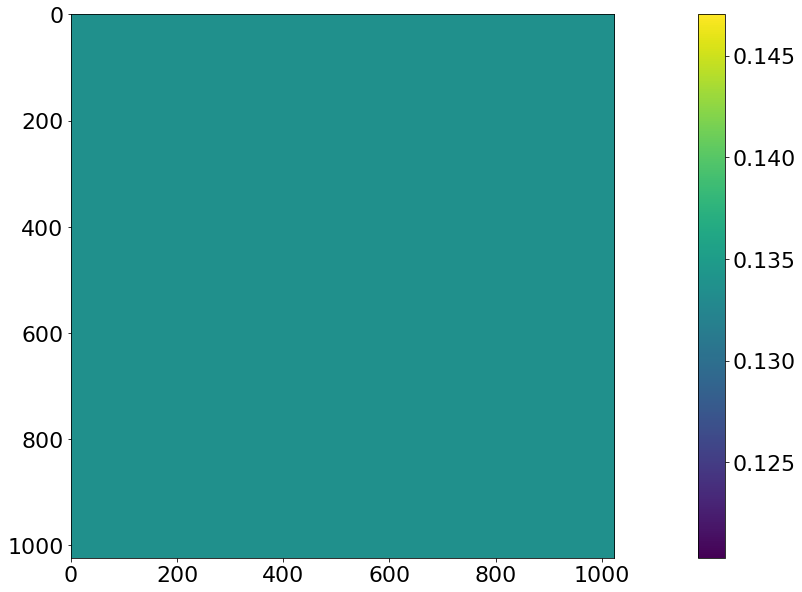

In [20]:
plt.imshow(model2.predict(PatternGamma[5:6,:,:])[0,:,:,0])
plt.colorbar()

After going through this process of using a neural network, I realized I think this problem may make more sense to solve practically using a different method, like gradient descent. I found a paper that simply does a least squares optimization: Muñoz, A., Flores, J. L., Parra-Escamilla, G., Morales, L. A., Ordones, S., & Servin, M. (2021). Least-squares gamma estimation in fringe projection profilometry. Applied Optics, 60(5), 1137-1142. In practice, if you wanted to calibrate for gamma distortion, you could do something like this

1. Project phase shifted fringe patterns onto a flat surface. Apply initial gamma value.
3. Calculate phase and unwrap phase
4. Calculate RMS phase error from a plane (cost function). 
5. Iterate gamma a small step up or down depending on if the last loop got better or worse
6. Repeat 1-5 until convergence

This should eventually converge on the gamma value, since the closer you get to the correct value, the better the RMS phase error. 